MLP implementation

In [1]:
from pathlib import Path

is_colab = True

try:
    from google.colab import drive

    drive.mount('/content/drive')
except ModuleNotFoundError:
    is_colab = False

print("Is running colab?", is_colab)

Is running colab? False


In [2]:
if is_colab:
    data_dir = Path('/content/drive/MyDrive/data')
    code_dir = Path('/content/drive/MyDrive/code')
    models_dir = Path('/content/drive/MyDrive/models/mlp')
else:
    data_dir = Path('data').resolve()
    models_dir = Path('models').resolve()

print(data_dir)

D:\ai-roadmap\content\dl\mlp\data


In [3]:
if is_colab:
    import shutil
    shutil.copy(code_dir / 'mlp/dataset.py',
                'dataset.py')

    shutil.copy(code_dir / 'mlp/chars.json',
                'chars.json')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from dataset import get_all_stories, get_dataset, CharacterLevelTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cpu


In [5]:
train_stories, val_stories, test_stories = get_all_stories(data_dir)

In [6]:
tokenizer = CharacterLevelTokenizer()
vocab_size = tokenizer.vocab_size

In [7]:
block_size=4
Ds_tr = get_dataset(train_stories, tokenizer, block_size=block_size)
Ds_val = get_dataset(val_stories, tokenizer, block_size=block_size)
Ds_test = get_dataset(test_stories, tokenizer, block_size=block_size)

In [8]:
Xtr, Ytr = Ds_tr.tensors
Xval, Yval = Ds_val.tensors

In [9]:
print(Xtr)
print(Ytr)

tensor([[ 0,  0,  0,  0],
        [ 0,  0,  0, 14],
        [ 0,  0, 14,  2],
        ...,
        [48, 45, 58, 59],
        [45, 58, 59,  8],
        [58, 59,  8, 40]])
tensor([14,  2, 31,  ...,  8, 40,  0])


In [10]:
Tr_loader = DataLoader(Ds_tr, batch_size=4)
Val_loader = DataLoader(Ds_val, batch_size=4)
Test_loader = DataLoader(Ds_test, batch_size=4)

In [11]:
@torch.no_grad()
def find_loss(model, X, Y):
    model.eval()
    X, Y = X.to(device), Y.to(device)
    logits = model(X)
    loss = F.cross_entropy(logits, F.one_hot(Y, vocab_size).float())
    # for param in bigram_model.parameters():
    #     loss += param.pow(2).mean().sqrt()
    return loss.item()

In [12]:
@torch.no_grad()
def generate(model, start_token=0, generator=None, k=None):
    model.eval()
    context = [start_token]*block_size
    out = []

    while True:
        logits = model(torch.tensor(context))[-1]
        if k:
            top_k_values, top_k_indices = torch.topk(logits, k)
            top_k_mask = torch.full_like(logits, float('-inf'))
            top_k_mask.scatter_(0, top_k_indices, top_k_values)
            logits = top_k_mask
        p = torch.softmax(logits, 0)
        # print(p)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=generator).item()
        if ix == start_token:
            break
        # print(context, ix)
        context = context[1:] + [ix]
        out.append(ix)
    return out

In [13]:
class MLP(nn.Module):

    def __init__(self, vocab_size, n_dim, n_hidden, block_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_dim = n_dim
        self.n_hidden = n_hidden
        self.block_size = block_size
        self.emb = nn.Embedding(vocab_size, n_dim)
        self.fc1 = nn.Linear(block_size*n_dim, n_hidden)
        self.fc2 = nn.Linear(n_hidden, vocab_size)

    def forward(self, idx):
        out = self.emb(idx)
        out = out.view(-1, self.block_size*self.n_dim)
        out = self.fc1(out)
        out = F.tanh(out)
        logits = self.fc2(out)
        return logits

In [14]:
model = MLP(vocab_size=vocab_size, n_dim=32, n_hidden=200, block_size=block_size).to(device)

In [15]:
optimizer = optim.SGD(model.parameters())

In [16]:
all_loss = []

In [17]:
epochs = 3
model.train()

for epoch in range(epochs):
    lossi = []
    for x, y in Tr_loader:
        x, y = x.to(device=device), y.to(device=device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        # for param in bigram_model.parameters():
        #     loss += param.pow(2).mean().sqrt()

        lossi.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    all_loss.extend(lossi)
    torch.save(model.state_dict(), models_dir / f'mlp_ndim64_hidden400_block4__epoch{epoch+1}.pth')   
    print(
        f"Epoch {epoch+1}/{epochs}."
        f" Average Loss: {torch.tensor(lossi).mean():.3f}."
        f" Train Loss: {find_loss(model, Xtr, Ytr):.3f}."
        f" Val Loss: {find_loss(model, Xval, Yval):.3f}"
    )

Epoch 1/3. Average Loss: 2.823. Train Loss: 2.474. Val Loss: 2.531
Epoch 2/3. Average Loss: 2.382. Train Loss: 2.301. Val Loss: 2.377
Epoch 3/3. Average Loss: 2.250. Train Loss: 2.196. Val Loss: 2.285


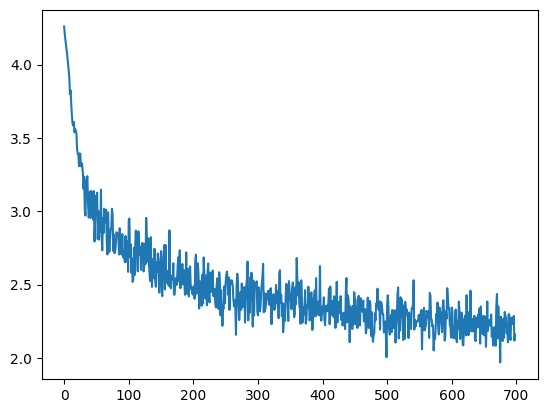

In [18]:
n = 100
plt.plot(torch.tensor(all_loss[:len(all_loss) // n * n]).view(-1, n).mean(1))
plt.show()

In [20]:
print("Train Loss:", find_loss(model, Xtr, Ytr))
print("Val Loss:", find_loss(model,Xval, Yval))

Train Loss: 2.195702314376831
Val Loss: 2.2849271297454834


In [21]:
g = torch.Generator().manual_seed(420)
ids = generate(model, generator=g, k=5)

print(tokenizer.decode(ids))

 toor a ter the casting ind, to serase to seren in wored. Buge soute hit of and, the sare and
s he teadender the hit
on in wather seasting huthim she war sath tham had she simed. Bis the wo the hame to cangery wound hisenther hand the han to she to sile tho foon the tor
the sand stenth must thamesting, bothighan they was tol he wat his that ind hin to the couthe coulleng se and the seran sas wast hur sas areend the sout th much as angede hid to hes he co aron the sild.

_Din seryoutery outing, bor ate chas was to to th the shand withe

"ast oreed the she wareres and an the his of thind aid the were he cale, and and ath thit and ting and so dint the

areed thin with sere to tiet and at he whin the to tho soor and the the tier. The Fo the cores of his the hise folly had bren tast the tor whit. are the wath thise anging, wald to hind tor the cont and simy so her has ande tas aroushim sound sase fire to chistof sis is aris wot ond are to hom warded, he hing and sher and wis in toon tho sim

---

In [ ]:
class MLP_Dropout(nn.Module):

    def __init__(self, vocab_size, n_dim, n_hidden, block_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_dim = n_dim
        self.n_hidden = n_hidden
        self.block_size = block_size
        self.emb = nn.Embedding(vocab_size, n_dim)
        self.fc1 = nn.Linear(block_size*n_dim, n_hidden)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(n_hidden, vocab_size)

    def forward(self, idx):
        out = self.emb(idx)
        out = out.view(-1, self.block_size*self.n_dim)
        out = self.fc1(out)
        out = F.tanh(out)
        out = self.dropout(out)
        logits = self.fc2(out)
        return logits

In [ ]:
model_drop = MLP_Dropout(vocab_size=vocab_size, n_dim=64, n_hidden=400, block_size=block_size).to(device=device)
optimizer_drop = optim.SGD(model_drop.parameters())
all_loss = []

In [ ]:
epochs = 3
model_drop.train()

for epoch in range(epochs):
    lossi = []
    for x, y in Tr_loader:
        x, y = x.to(device=device), y.to(device=device)
        logits = model_drop(x)
        loss = F.cross_entropy(logits, y)
        # for param in bigram_model.parameters():
        #     loss += param.pow(2).mean().sqrt()

        lossi.append(loss.item())

        optimizer_drop.zero_grad()
        loss.backward()
        optimizer_drop.step()

    all_loss.extend(lossi)
    torch.save(model_drop.state_dict(), models_dir / f'mlp_drop_ndim64_hidden400_block4__epoch{epoch+1}.pth')
    print(
        f"Epoch {epoch+1}/{epochs}."
        f" Average Loss: {torch.tensor(lossi).mean():.3f}."
        f" Train Loss: {find_loss(model_drop, Xtr, Ytr):.3f}."
        f" Val Loss: {find_loss(model_drop, Xval, Yval):.3f}"
    )

In [ ]:
g = torch.Generator(device=device).manual_seed(42)
ids = generate(model_drop, generator=g, k=10)

print(tokenizer.decode(ids))